In [1]:
from rocket import Rocket, Motor
from rocket_comp import Rocket_Comp, Burn
import numpy as np
import numpy.linalg as npla
from tqdm import tqdm

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"

In [2]:
# Planet Parameters (Earth Moon)

RADIUS = np.float64(1738.1e3) # m
ROT_SPEED = 2.654e-6          # radians/second
GM = np.float64(4.9048695e12) # m^3/s^2

In [3]:
# Rocket Parameters (Apollo 11 Ascent Stage)
# Mass: kg
# Distance: m

mass_rocket = 0               # kg (0 for now just putting all dry mass on motor weight)
ap11_motor = Motor(2287, 4200, 4.33, 3600) # dry mass (kg), wet mass(kg), fuel ejection rate (kg/s), fuel ejection speed (m/s)

initial_pos = np.array([0, 0, RADIUS])
initial_vel = np.array([ROT_SPEED*RADIUS, 0, 0])
initial_dir = np.array([1, 0, 2])

rocket = Rocket(mass_rocket, initial_pos, initial_vel, initial_dir, ap11_motor, GM, RADIUS)

dt = np.float16(5*1e-2)
upp_lim = int(1e5)

times = []
alts = []
speeds = []
apogees = []
perigees = []
burn_time = 0
delta_vs = []

xs = []
ys = []
zs = []

ap_target = 5e6

rocket.throttle(1)

launch_init_pos = rocket.pos
launch_end_pos = None

burn_init_pos = None
burn_end_pos = None

ap_reached = False
orb_burn = False

curr_burn = None
rc = Rocket_Comp(rocket, None)

for i in tqdm(range(0, upp_lim)):

    # Logging
    times.append(rocket.clock)
    alts.append(rocket.get_radial_dist()-RADIUS)
    speeds.append(rocket.get_speed())
    xs.append(rocket.pos[0])
    ys.append(rocket.pos[1])
    zs.append(rocket.pos[2])
    delta_vs.append(rocket.get_delta_v())
    apogees.append(rocket.get_apogee())
    perigees.append(rocket.get_perigee())
    
    if rocket.get_altitude() < 1e2:
        dt = 0.01
    if rocket.get_altitude() < 1e4:
        dt = 0.05
    elif rocket.get_altitude() < 1e6:
        dt = 0.5
    elif rocket.get_altitude() < 1e7:
        dt = 1

    if rocket.get_apogee() > ap_target and not(ap_reached):
        rocket.throttle(0)
        launch_end_pos = rocket.pos
        ap_reached = True
    elif rocket.get_radial_dist() >= ap_target-1e5 and not(orb_burn):
        curr_burn = rc.get_circular_burn(np.pi, rocket.get_apogee())
        print("Burn Init: " + str(curr_burn.init_t))
        print("Burn Final: " + str(curr_burn.final_t))
        orb_burn = True

    if curr_burn != None:
        if(rocket.clock >= curr_burn.init_t and rocket.clock <= curr_burn.final_t):
            dt = (curr_burn.final_t - curr_burn.init_t) / 1000
            rocket.throttle(curr_burn.throttle)
            rocket.set_dir(curr_burn.get_dir())
        elif(rocket.clock > curr_burn.final_t):
            burn_end_pos = rocket.pos
            curr_burn = None
            rocket.throttle(0)
        else:
            if(rocket.clock + dt > curr_burn.init_t):
                burn_init_pos = rocket.pos
                dt = curr_burn.init_t - rocket.clock
        
    rocket.update_pos(dt)
    rocket.update_orbit()
    rocket.update_mass(dt)

    if(rocket.get_radial_dist() < RADIUS):
        break

 10%|█         | 10198/100000 [00:01<00:14, 6243.71it/s]

Required: 619.8858090047954, [ 6.40853727e+02  1.24684121e-13 -7.54538763e+02]
Current: 1092.0480165591391, [ 2.39568990e+02  4.66104003e-14 -2.82067625e+02]
Burn Init: 6013.826894797107
Burn Final: 6126.9822074465055


100%|██████████| 100000/100000 [00:15<00:00, 6255.16it/s]


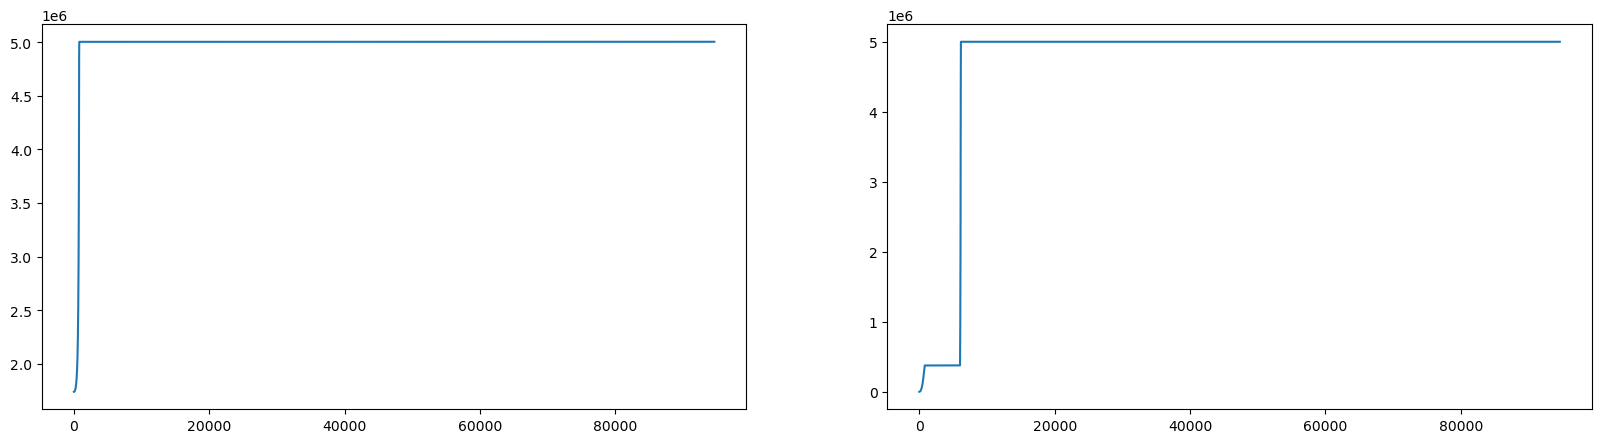

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(times, apogees)
axes[1].plot(times, perigees)
plt.show()

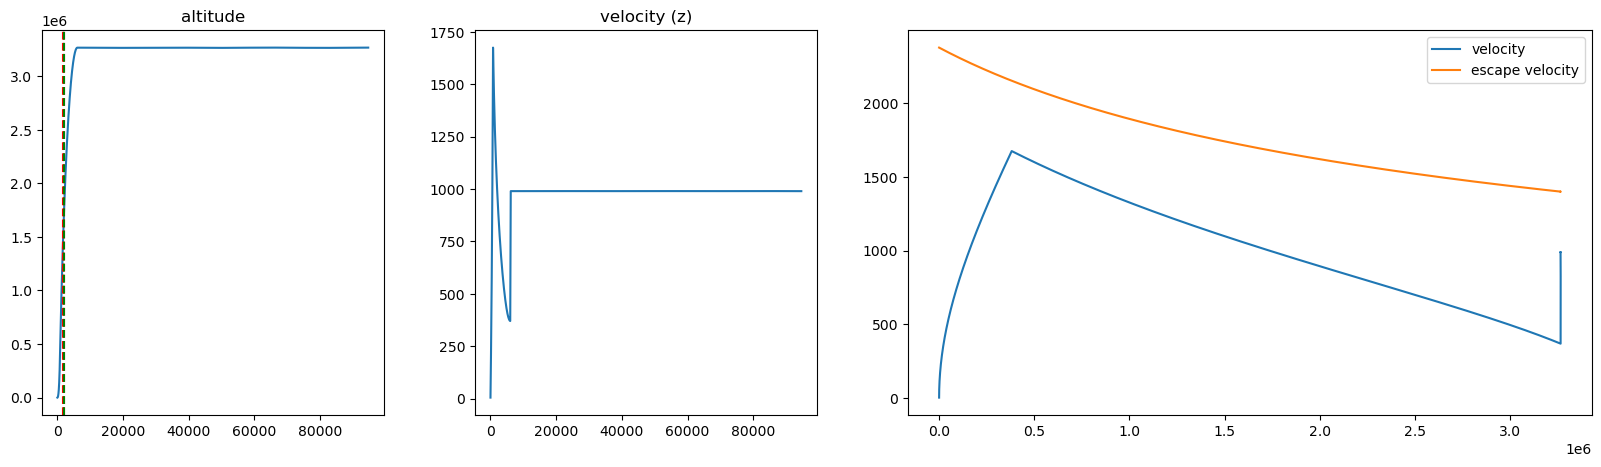

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 2]})

axes[0].plot(times, alts)
axes[0].set_title('altitude')

axes[0].axvline(x=1810.2217221272563, color='red', linestyle='--')
axes[0].axvline(x=1983.5988806429677, color='red', linestyle='--')
axes[0].axvline(x=1896.910301385112, color='green', linestyle='--')

axes[1].plot(times, speeds)
axes[1].set_title('velocity (z)')
axes[2].plot(alts, speeds, label = 'velocity')
axes[2].plot(alts, np.sqrt(2*GM/(RADIUS+alts)), label = 'escape velocity')
axes[2].legend(fontsize=10)
plt.show()

Text(0.5, 1.0, 'delta v (m/s)')

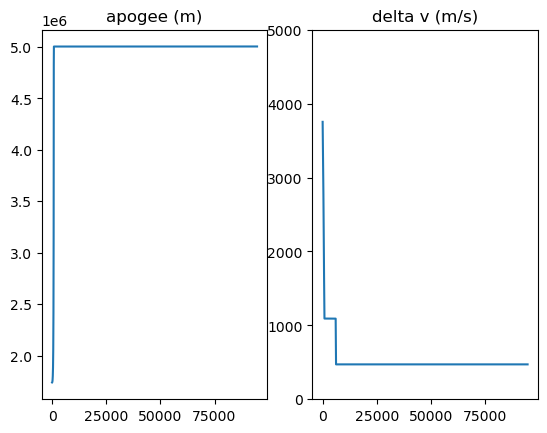

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(times, apogees)
axes[0].set_title("apogee (m)")
axes[1].plot(times, delta_vs)
axes[1].set_ylim(0, 5000)
axes[1].set_title("delta v (m/s)")

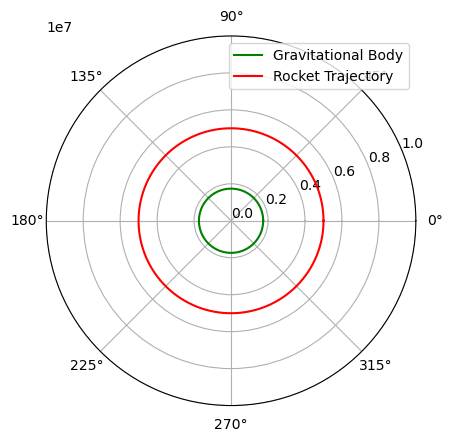

In [7]:
from calc_orb_traj import plot_traj_around_planet, calculate_orbital_parameters, plot_predicted_orbit

orb_params = calculate_orbital_parameters(rocket.pos, rocket.vel, rocket.GM)

plot_predicted_orbit(orb_params, RADIUS, rmin=0, rmax=1e7, num_ticks=6)
plt.show()

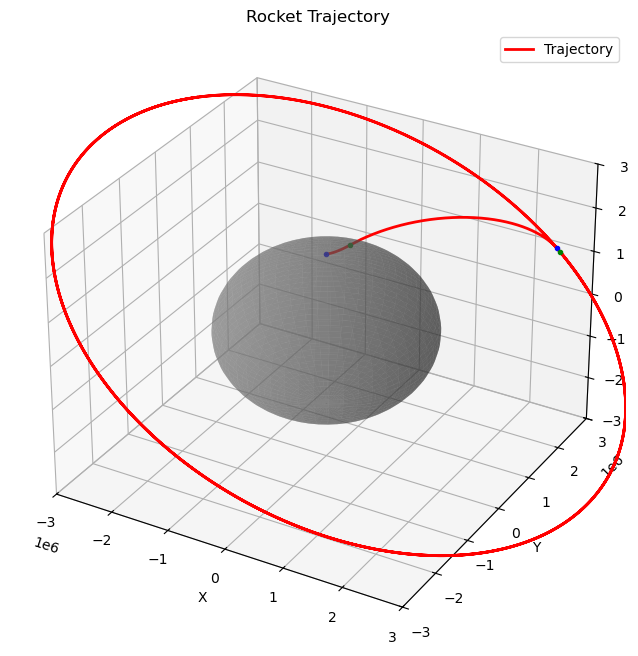

In [8]:
plot_traj_around_planet(RADIUS, xs, ys, zs, xlims=[-3e6, 3e6], ylims=[-3e6, 3e6], zlims=[-3e6, 3e6])

plt.plot(launch_init_pos[0], launch_init_pos[1], launch_init_pos[2], color='blue', marker='o', markersize=3)
plt.plot(launch_end_pos[0], launch_end_pos[1], launch_end_pos[2], color='green', marker='o', markersize=3)

plt.plot(burn_init_pos[0], burn_init_pos[1], burn_init_pos[2], color='blue', marker='o', markersize=3)
plt.plot(burn_end_pos[0], burn_end_pos[1], burn_end_pos[2], color='green', marker='o', markersize=3)

plt.show()

In [9]:
a = rocket.orbit.a
b = np.sqrt(1-np.power(rocket.orbit.e, 2))

print(100*(1 - b/a))

99.99998001672094
